In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# GLOBALS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 


TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



In [12]:
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed_no_chrY.npy')
# contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')

In [ ]:
import core.optimizer

TTN_BINS = [4275, 4276, 4277, 4278]

for bin in TTN_BINS: 
    core.optimizer.optimize_clique_size(contact_matrix_zero, 50, bin, num_samples=1000)

Starting optimize_clique_size: max_clique_size=10, seed_bin=4275, num_samples=100, alg=find_greedy_clique
Computed TTN full clique of size 10 using find_greedy_clique


Sampling background cliques: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Background sampling complete.


Processing sizes: 100%|██████████| 10/10 [00:00<00:00, 1986.50it/s]


Completed optimize_clique_size
Starting optimize_clique_size: max_clique_size=10, seed_bin=4276, num_samples=100, alg=find_greedy_clique
Computed TTN full clique of size 10 using find_greedy_clique


Sampling background cliques: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Background sampling complete.


Processing sizes: 100%|██████████| 10/10 [00:00<00:00, 1207.62it/s]


Completed optimize_clique_size
Starting optimize_clique_size: max_clique_size=10, seed_bin=4277, num_samples=100, alg=find_greedy_clique
Computed TTN full clique of size 10 using find_greedy_clique


Sampling background cliques: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Background sampling complete.


Processing sizes: 100%|██████████| 10/10 [00:00<00:00, 1464.13it/s]


Completed optimize_clique_size
Starting optimize_clique_size: max_clique_size=10, seed_bin=4278, num_samples=100, alg=find_greedy_clique
Computed TTN full clique of size 10 using find_greedy_clique


Sampling background cliques: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Background sampling complete.


Processing sizes: 100%|██████████| 10/10 [00:00<00:00, 1471.69it/s]

Completed optimize_clique_size


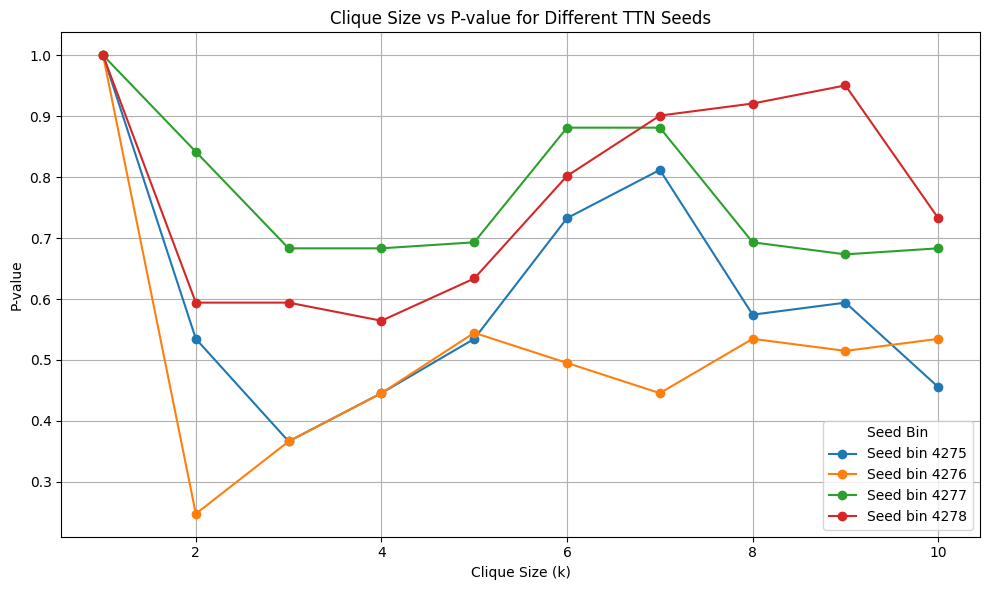

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

TTN_BINS = [4275, 4276, 4277, 4278]
clique_sizes = [1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(10, 6))

for seed_bin in TTN_BINS:
    # Load CSV
    df = pd.read_csv(f'greedy_clique_size_optimization_results_seed_{seed_bin}.csv')
    
    # Filter to desired clique sizes
    df_filtered = df[df['size'].isin(clique_sizes)]
    
    # Plot p-value vs. clique size
    plt.plot(
        df_filtered['size'],
        df_filtered['p_value'],
        marker='o',
        label=f'Seed bin {seed_bin}'
    )

plt.xlabel('Clique Size (k)')
plt.ylabel('P-value')
plt.title('Clique Size vs P-value for Different TTN Seeds')
plt.legend(title='Seed Bin')
plt.grid(True)
plt.tight_layout()
plt.show()

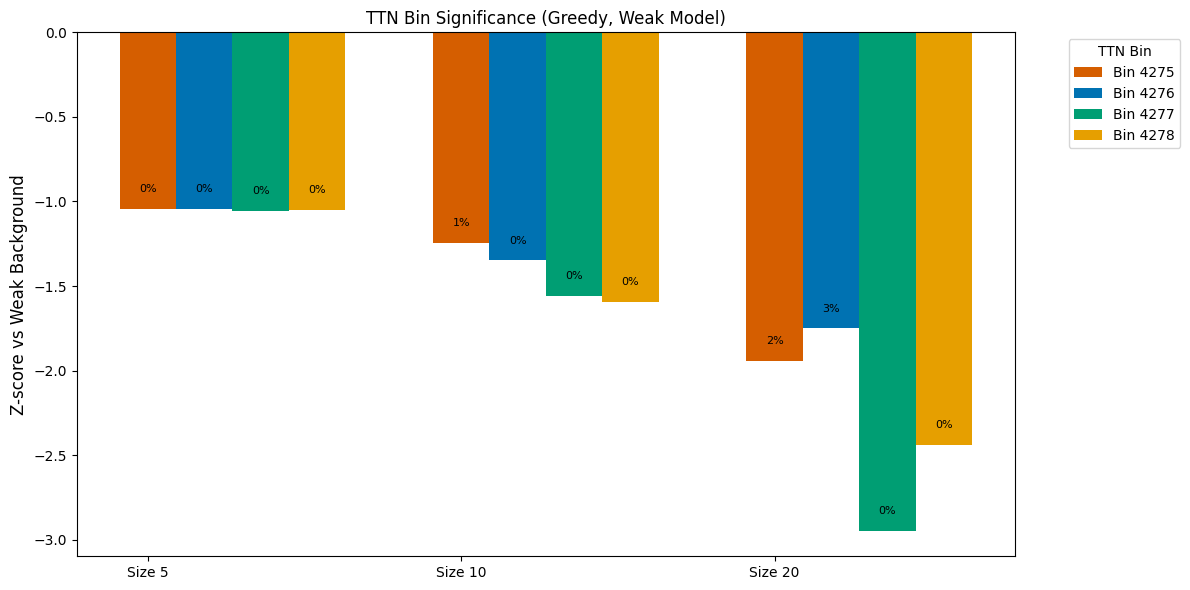

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore, zscore

clique_sizes = [5, 10, 20]
num_iterations = 1000
ttn_bins = [4275, 4276, 4277, 4278]
colors = ['#D55E00', '#0072B2', '#009E73', '#E69F00']  # colorblind‐friendly

bin_map = f.load_bin_map(BIN_MAP_PATH)
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.18
x_labels = []
xticks = []
all_heights = []

for i, size in enumerate(clique_sizes):
    # Compute scores
    ttn_cliques = [cf.find_greedy_clique(contact_matrix_zero, size, b) for b in ttn_bins]
    ttn_scores = [core.stats.calculate_avg_interaction_strength(contact_matrix_zero, c) for c in ttn_cliques]

    # Load background
    with open(f'background_models/greedy/greedy_scores_{size}_iterations_{num_iterations}_weak.txt', 'r') as f_weak:
        bg_weak = np.array([float(line) for line in f_weak])

    bg_mean, bg_std = np.mean(bg_weak), np.std(bg_weak)

    for j, (score, bin_id) in enumerate(zip(ttn_scores, ttn_bins)):
        z = (score - bg_mean) / bg_std
        percentile = percentileofscore(bg_weak, score)
        x = i + j * bar_width
        ax.bar(x, z, color=colors[j], width=bar_width, label=f'Bin {bin_id}' if i == 0 else "")
        ax.text(x, z + 0.1, f'{percentile:.0f}%', ha='center', fontsize=8)
        if i == 0:
            xticks.append(j * bar_width + 1.5)
            x_labels.append(f'Bin {bin_id}')

# Styling
ax.set_xticks(range(len(clique_sizes)))
ax.set_xticklabels([f'Size {s}' for s in clique_sizes])
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_ylabel('Z-score vs Weak Background', fontsize=12)
ax.set_title('TTN Bin Significance (Greedy, Weak Model)')
ax.legend(title='TTN Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


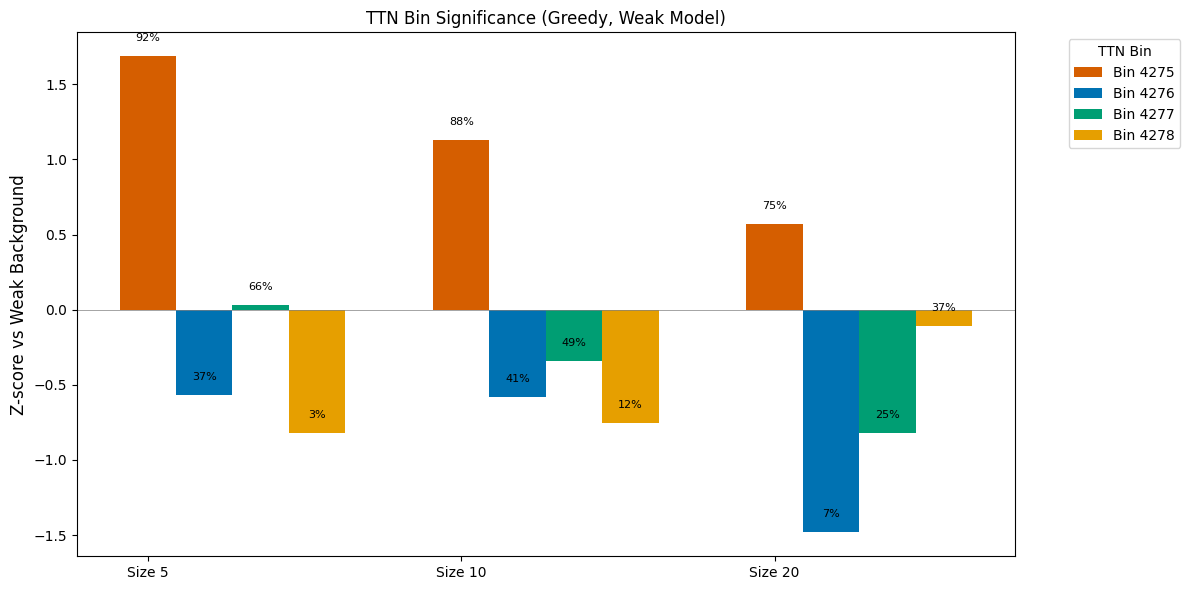

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore, zscore

clique_sizes = [5, 10, 20]
num_iterations = 1000
ttn_bins = [4275, 4276, 4277, 4278]
colors = ['#D55E00', '#0072B2', '#009E73', '#E69F00']  # colorblind‐friendly

bin_map = f.load_bin_map(BIN_MAP_PATH)
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.18
x_labels = []
xticks = []
all_heights = []

for i, size in enumerate(clique_sizes):
    # Compute scores
    ttn_cliques = [cf.find_greedy_clique(contact_matrix_zero, size, b) for b in ttn_bins]
    ttn_scores = [core.stats.calculate_avg_interaction_strength(contact_matrix_zero, c) for c in ttn_cliques]

    # Load background
    with open(f'background_models/greedy/greedy_scores_{size}_iterations_{num_iterations}_weak.txt', 'r') as f_weak:
        bg_weak = np.array([float(line) for line in f_weak])

    bg_mean, bg_std = np.mean(bg_weak), np.std(bg_weak)

    for j, (score, bin_id) in enumerate(zip(ttn_scores, ttn_bins)):
        z = (score - bg_mean) / bg_std
        percentile = percentileofscore(bg_weak, score)
        x = i + j * bar_width
        ax.bar(x, z, color=colors[j], width=bar_width, label=f'Bin {bin_id}' if i == 0 else "")
        ax.text(x, z + 0.1, f'{percentile:.0f}%', ha='center', fontsize=8)
        if i == 0:
            xticks.append(j * bar_width + 1.5)
            x_labels.append(f'Bin {bin_id}')

# Styling
ax.set_xticks(range(len(clique_sizes)))
ax.set_xticklabels([f'Size {s}' for s in clique_sizes])
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_ylabel('Z-score vs Weak Background', fontsize=12)
ax.set_title('TTN Bin Significance (Greedy, Weak Model)')
ax.legend(title='TTN Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
